In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *

In [2]:
tid = 29984014

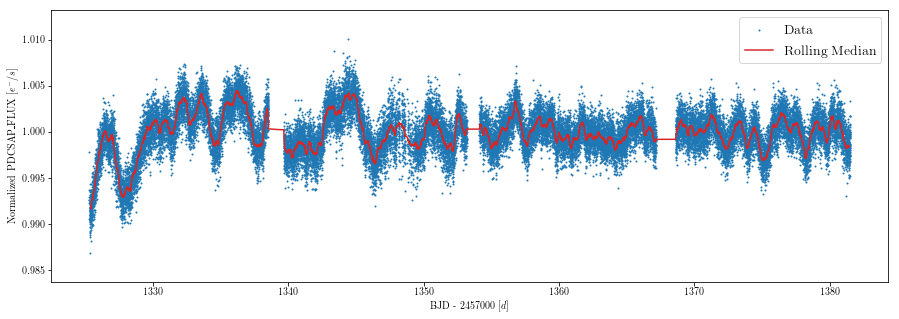

In [3]:
fig = plt.figure(figsize=(15,5))
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
plt.scatter(lc['Time'],lc['Flux'],s=1,label='Data')
plt.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C3',label='Rolling Median')
plt.gca().set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:110: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


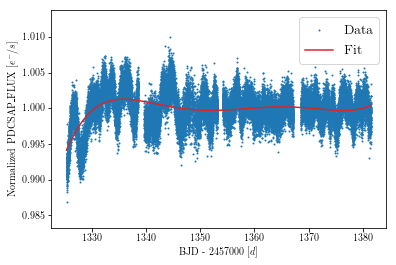

In [4]:
lc, p = polynorm(lc, deg=7)
vals = np.polyval(p, lc['Time'])
plt.scatter(lc['Time'],lc['Flux'],s=1,label='Data')
plt.plot(lc['Time'],vals,c='C3',label='Fit')
plt.gca().set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

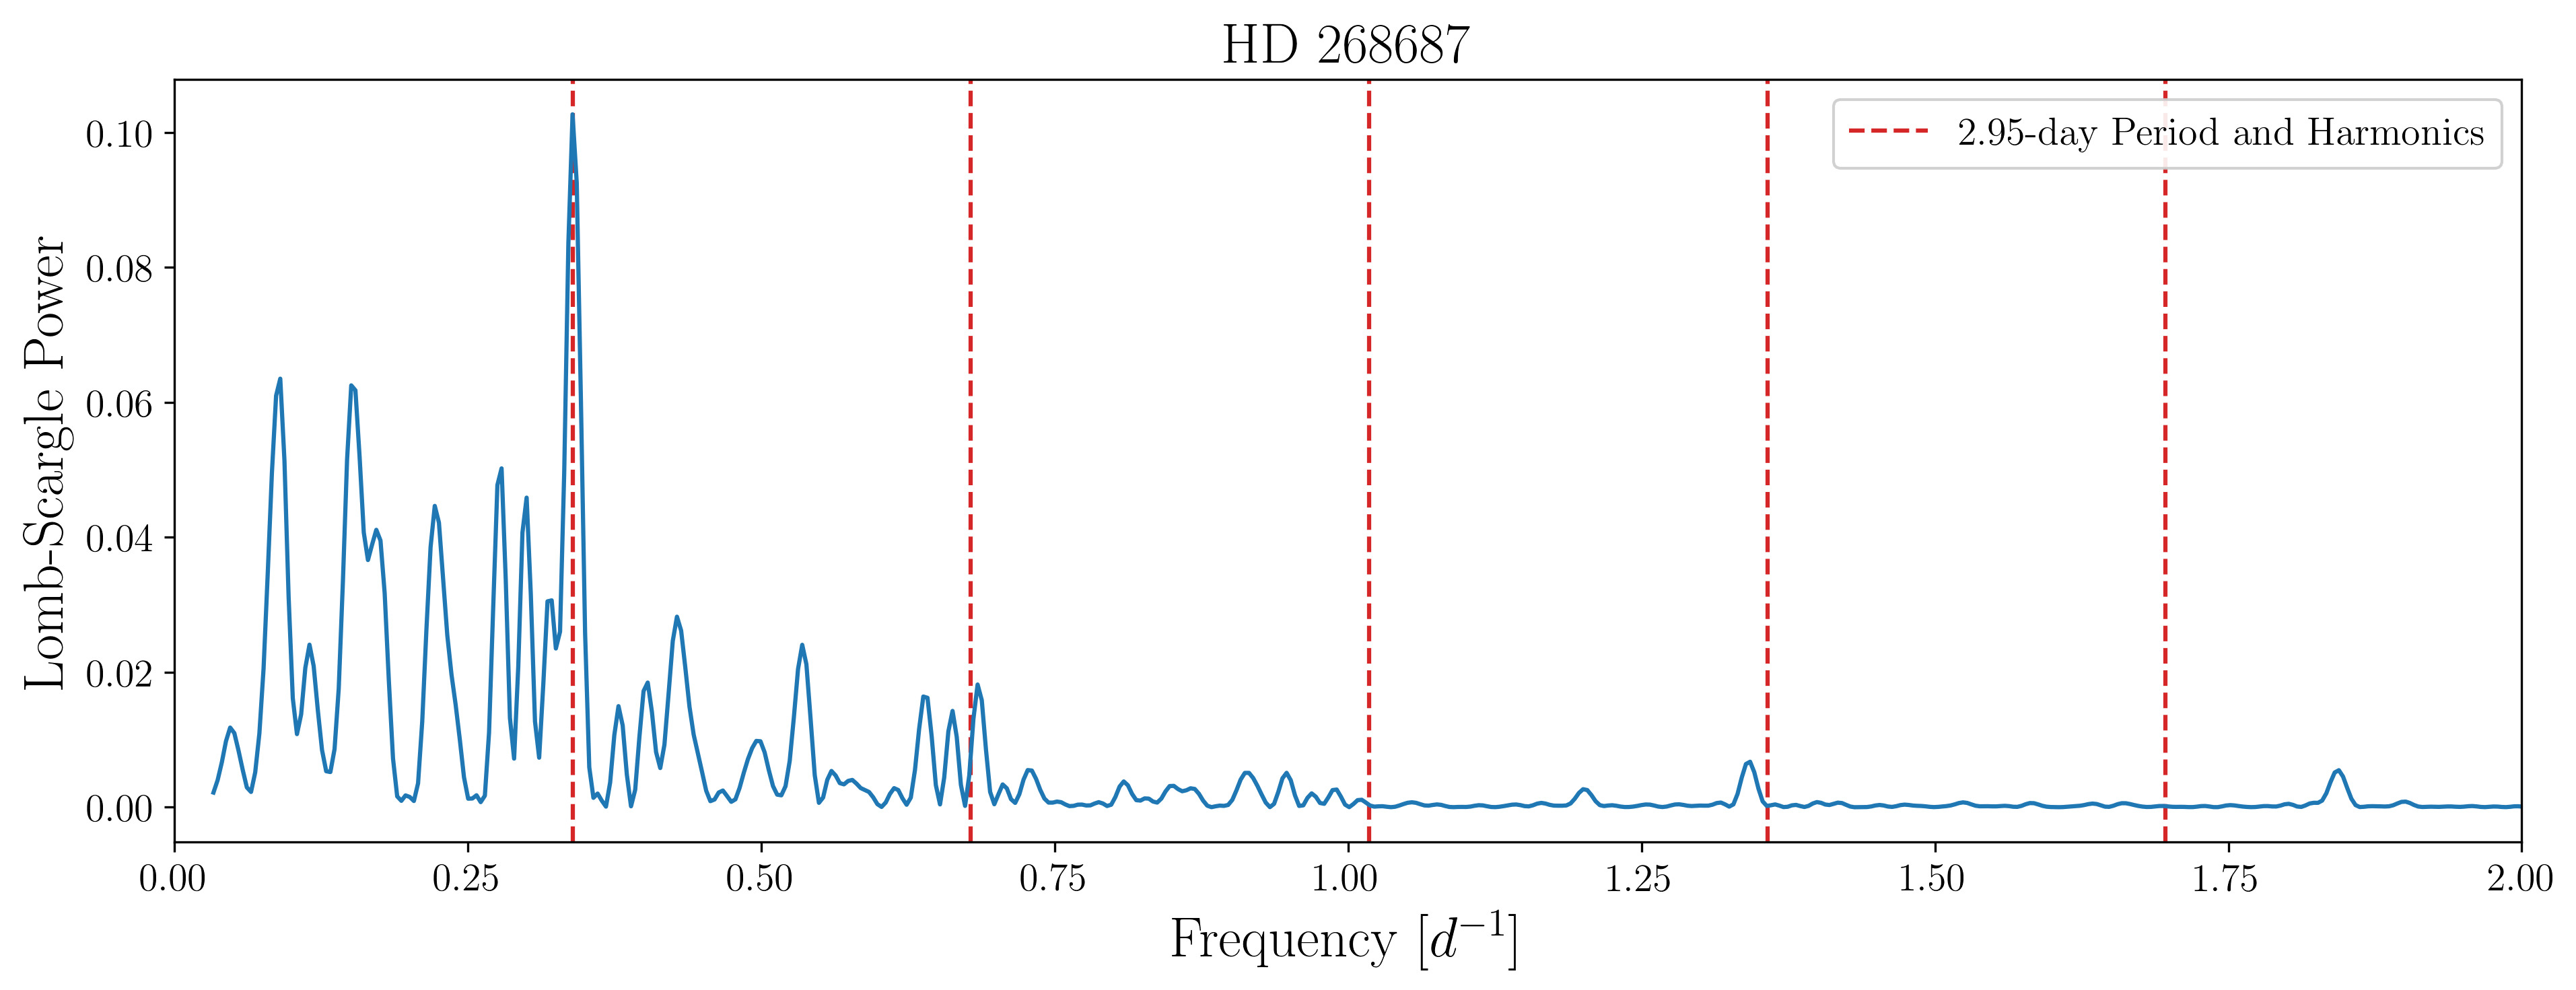

In [6]:
ls = LombScargle(lc['Time'], lc['NormFlux'])
f, p = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=1.0/0.1)

fs, ps = peak_finder(f, p, 10, width=10)

dom = fs[np.argmax(ps)]
dp = 1.0/dom

fig = plt.figure(figsize=(15,5),dpi=300)
plt.plot(f,p)
for i in np.arange(1,6):
    if i == 1:
        plt.axvline(x=(i*dom), ls='--', c='C3', zorder=-1, label='{0:.2f}-day Period and Harmonics'.format(dp))
    else: 
        plt.axvline(x=(i*dom), ls='--', c='C3',zorder=-1)        

plt.legend(loc=1, framealpha=0.9, prop={'size': 14})
ax = plt.gca()
ax.set(xlabel='Frequency [$d^{-1}$]', ylabel='Lomb-Scargle Power',xlim=(0,2));
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 268687',fontsize=20)    
plt.savefig('../plots/HD268687_periodogram.pdf')

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


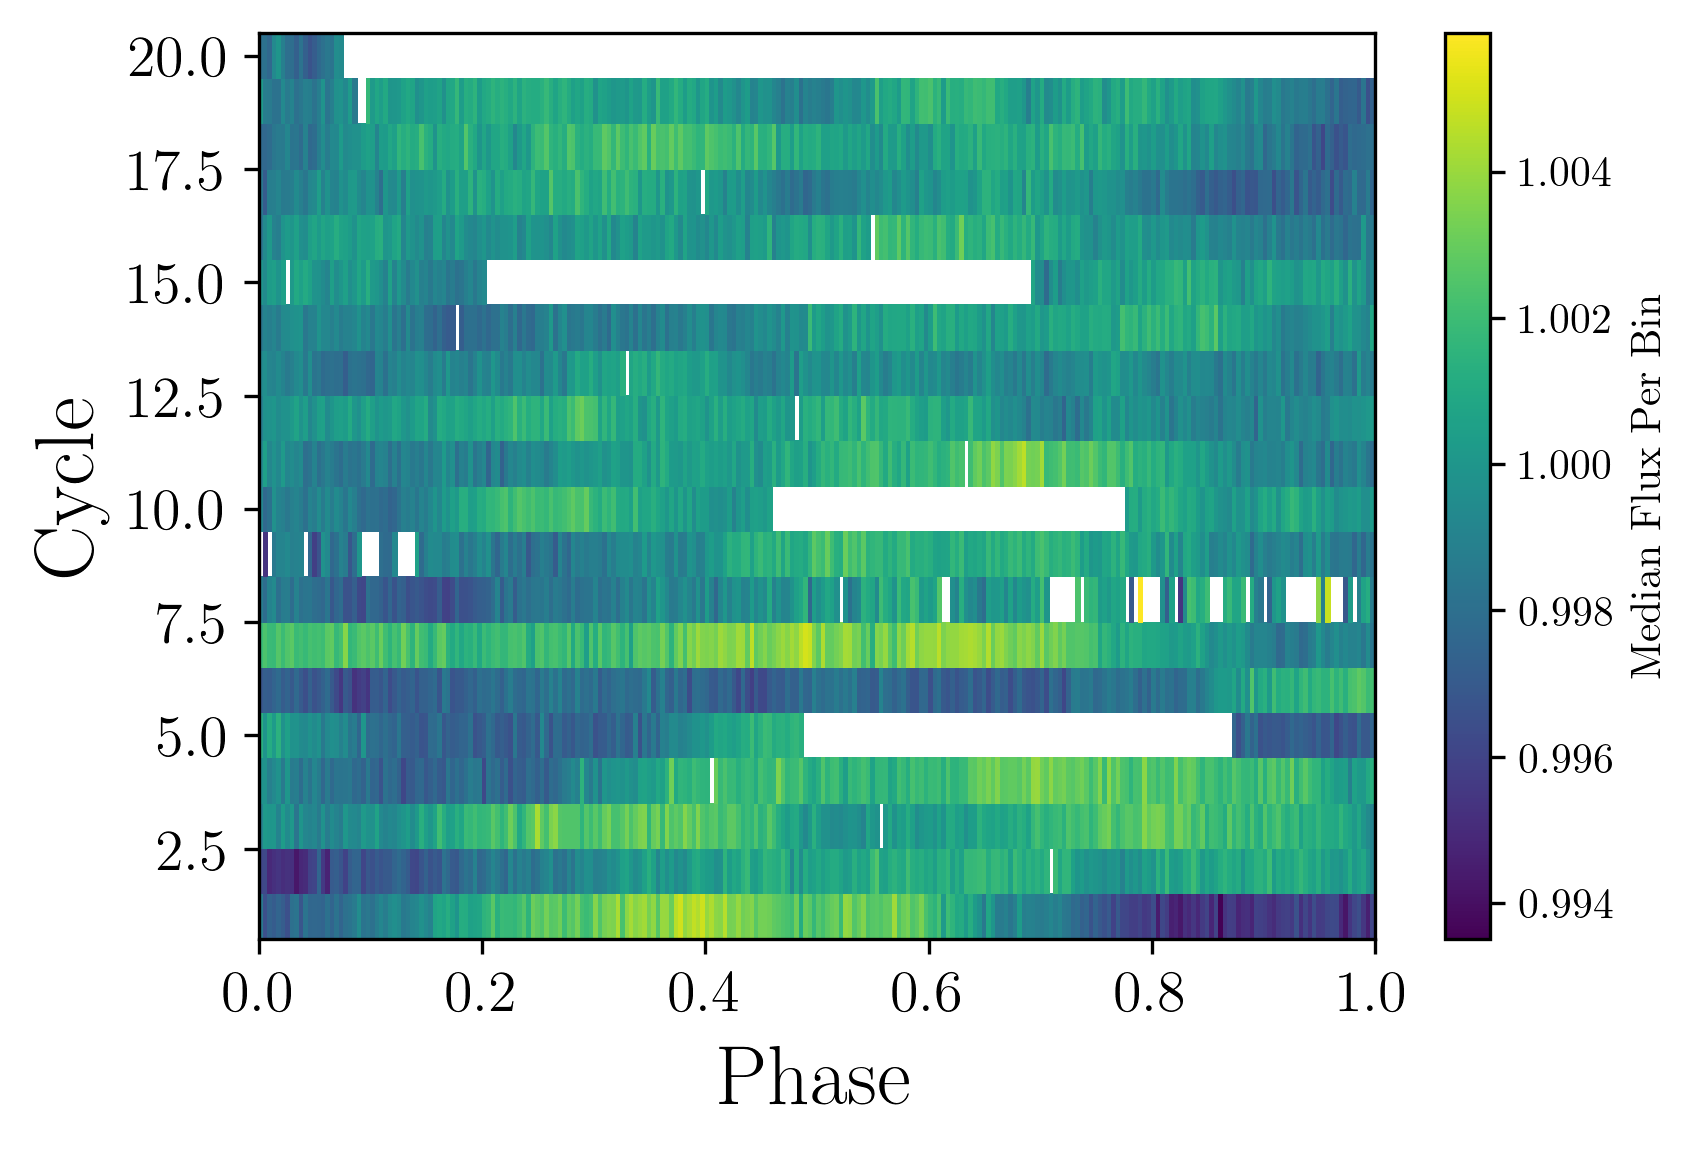

In [16]:
fig = plt.figure(dpi=300)
cycle = np.floor((lc['Time']-np.min(lc['Time']))*dom)
phase = ((lc['Time']-np.min(lc['Time']))*dom) % 1
flux = lc['NormFlux']
ybins = len(np.unique(cycle))
xbins = 250
H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  
H = np.ma.masked_where(H==0, H) #masking where there was no data
XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
colobj = plt.pcolormesh(XX,YY,H.T)
plt.xlabel('Phase')
plt.ylabel('Cycle')
ax = plt.gca()
plt.colorbar(colobj, ax=ax, label='Median Flux Per Bin')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.savefig('../plots/HD268687_dynamic.pdf')

In [8]:
dom
1/0.339

2.949852507374631

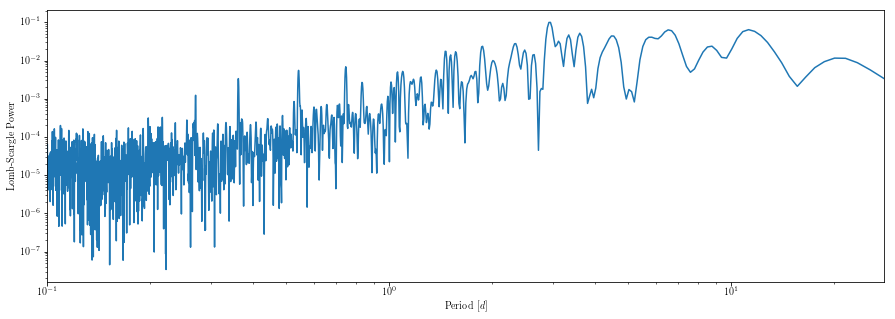

In [9]:
f, p = ls.autopower(minimum_frequency=1.0/28.0,
                    maximum_frequency=1.0/0.1)

fig = plt.figure(figsize=(15,5))
plt.loglog(1.0/f,p)
plt.gca().set(xlabel='Period [$d$]', ylabel='Lomb-Scargle Power', xlim=(0.1,28));

In [10]:
# Now let's do some of the GP stuff on this with twin SHOs
gp = dSHO_maxlikelihood(lc)

Initial log likelihood: 184986.72398259552
Final log likelihood: 187544.4837446413
Maximum Likelihood Soln: OrderedDict([('kernel:terms[0]:log_S0', -13.49745792672745), ('kernel:terms[0]:log_omega0', 0.9097796795498538), ('kernel:terms[1]:log_S0', -16.0), ('kernel:terms[1]:log_Q', -0.9401092705697506), ('kernel:terms[1]:log_omega0', 2.2305463948920363), ('kernel:terms[2]:log_sigma', -7.680636223458878)])


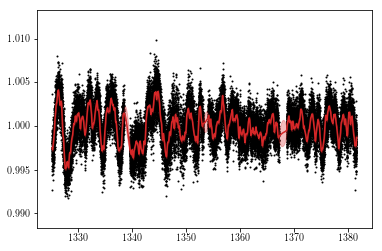

In [11]:
x = np.linspace(np.min(lc['Time']), np.max(lc['Time']), 5000)
pred_mean, pred_var = gp.predict(lc['NormFlux'], x, return_var=True)
pred_std = np.sqrt(pred_var)

plt.scatter(lc['Time'], lc['NormFlux'], s=1, c='k')
plt.plot(x, pred_mean, color='C3')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='C3', alpha=0.3,
                 edgecolor="none")

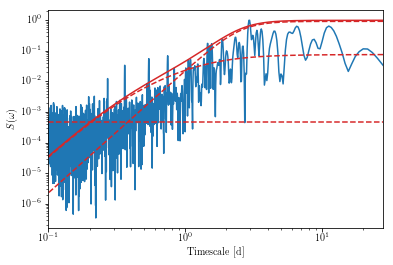

In [12]:
omega = np.exp(np.linspace(np.log(2.0*np.pi/28.0), np.log(2.0*np.pi/0.1), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(1.0/f,p/np.max(p),c='C0')
plt.plot(2.0*np.pi/omega, psd/np.max(psd), color='C3')
for k in gp.kernel.terms:
    plt.plot(2.0*np.pi/omega, k.get_psd(omega)/np.max(psd), "--", color='C3')
plt.axhline(y=np.exp(gp.kernel.terms[2].get_parameter_dict()['log_sigma']),ls='--', color='C3')

plt.yscale("log")
plt.xscale("log")
plt.xlim(2.0*np.pi/omega[-1], 2.0*np.pi/omega[0])
plt.xlabel("Timescale [d]")
plt.ylabel("$S(\omega)$");

In [13]:
sampler, gp = dSHO_emcee(lc, gp)

Running 500 steps of burn-in...


/Users/carina/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/carina/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Running 3000 steps of production...


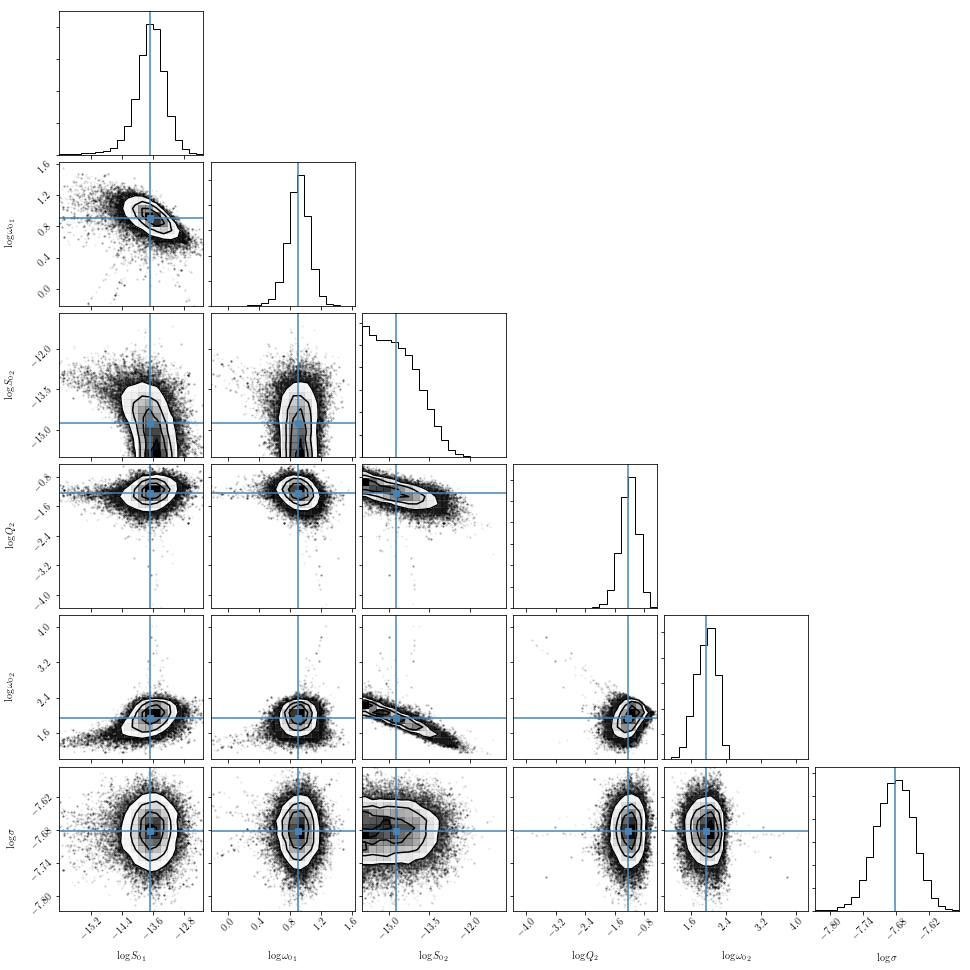

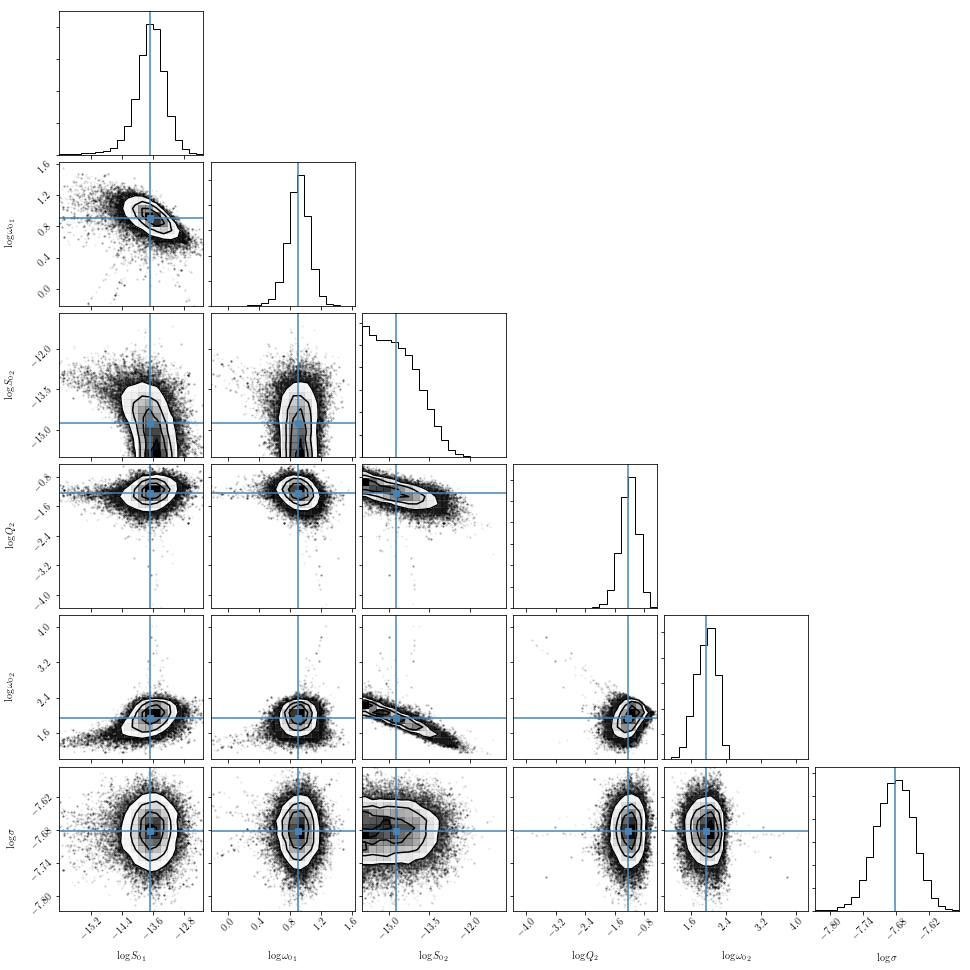

In [14]:
import corner
latex_names = ['$\log{S_0}_1$','$\log{\omega_0}_1$','$\log{S_0}_2$','$\log{Q}_2$','$\log{\omega_0}_2$','$\log{\sigma}$']
true_params = [np.mean(sampler.flatchain[:,i]) for i in range(sampler.flatchain.shape[1])]
corner.corner(sampler.flatchain, truths=true_params,
              labels=latex_names)

In [15]:
[tid]+true_params

[29984014,
 -13.683423480769171,
 0.9058719406272487,
 -14.742234224077091,
 -1.230619048118058,
 1.9376192227821758,
 -7.682152438109031]